<a href="https://colab.research.google.com/github/aggelospsiris/Book-ratings-guess-using-kmeans-and-neural-networks/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  1 19:35:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline
import array
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import re
import numpy as np



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv("/content/sample_data/BX-Users.csv")


**Dataframe preprocessing**

In [ ]:
#remove the columns that has nan vals
df = df.dropna()

In [ ]:
#remove the age less than 5 andd more than 100

df = df.drop(df[df['age'] >= 105].index)
df = df.drop(df[df['age'] <= 5].index)


**Locations preprocessing**

In [ ]:
locations_processed = []
location_processed = []
#for every location
for l in df.location:
  #split the location into words
  l = l.split(",")
  #for every word
  for word in l:
    #remove spaces
    word_striped = word.strip()
    #remove punktuation
    word_without_panktuation = re.sub(r'[^\w\s]', '', word_striped)
    #if the word has length less than 2 remove it
    if(len(word_without_panktuation)<2):
      word_with_more_than_one_char = ''
    else:
      word_with_more_than_one_char = word_without_panktuation
    #if the word is na remove it
    if(word_with_more_than_one_char != 'na' ):
      #if the word is space remove it
      if(word_with_more_than_one_char != '' ):
        #i remove all the spaces betwwen words so the built of the vectorizer will be easier
        location_processed.append(word_with_more_than_one_char.replace(" ", ""))
  #location_processed = ' '.join(s for s in location_processed)
  locations_processed.append(location_processed)
  location_processed= []
#convert every location into text again to feed it into the vectorizer
string_location = ''
string_locations = []
print(locations_processed[0:5])
for location in locations_processed:
  for word in location:
    string_location = string_location + " " + word
  string_locations.append(string_location)
  string_location = ''
string_locations[0:5]

[['stockton', 'california', 'usa'], ['porto', 'vngaia', 'portugal'], ['santamonica', 'california', 'usa'], ['melbourne', 'victoria', 'australia'], ['barcelona', 'barcelona', 'spain']]


[' stockton california usa',
 ' porto vngaia portugal',
 ' santamonica california usa',
 ' melbourne victoria australia',
 ' barcelona barcelona spain']

The best way to convert the locations into vectors would be to retrieve the cordinates of each location from openstreetmap because this way the can be represented in the 2d space like "[lat,lan]" and take the max perfomance(speed cause the input vectors would be only 3d and accuracy) from the k-means.Although because this proccess needs a lot of running time cause the data are a lot we need to parallize the code which is not the goal of this project so i wont follow this way.The block of code is an example of how we can retrive the coordinates.


In [ ]:
"""
import requests
import urllib.parse 
locations_processed = []
location_processed = []
#for every location
for l in df.location:
  #split the location into words
  l = l.split(",")
  #for every word
  for word in l:
    #remove spaces
    word_striped = word.strip()
    #remove punktuation
    word_without_panktuation = re.sub(r'[^\w\s]', '', word_striped)
    #if the word has length less than 2 remove it
    if(len(word_without_panktuation)<2):
      word_with_more_than_one_char = ''
    else:
      word_with_more_than_one_char = word_without_panktuation
    #if the word is na remove it
    if(word_with_more_than_one_char != 'na' ):
      #if the word is space remove it
      if(word_with_more_than_one_char != '' ):
        location_processed.append(word_with_more_than_one_char)
  #location_processed = ' '.join(s for s in location_processed)
  locations_processed.append(location_processed)
  location_processed= []

#print(locations_processed[0:5])
#get the cordinates of each location using request from openstreetmap
lat = []
lon = []
i = 0
for location in locations_processed:
  #The max len of a location is 3 althouth i put 4 to be sure
  if len(location) == 1:
    address = location[0]
  elif len(location) == 2:
    address = location[0] + ',' + location[1]
  elif len(location) == 3:
    address = location[0] + ',' + location[1] + ',' + location[2]
  elif len(location) == 4:
    address = location[0] + ',' + location[1] + location[2] + ',' + location[3]
  url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
  response = requests.get(url).json()
  try:
    lat.append(float(response[0]["lat"]))
    lon.append(float(response[0]["lon"]))
  except:
    lat.append(float("nan"))
    lon.append(float("nan"))
  i = i + 1
  print(i)

df['lat'] = lat
df['lon'] = lon
df = df.dropna()
df = df.drop(columns=['location'])

"""

**Locations vectorization**

To convert the locations into vectors i ll use sklearn Count Vectorizer that gives us a sparse vector with the size of the vocablary of all the locatios with 1s only in the words  that the location has

In [ ]:
from pandas.util.version import Version
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(string_locations)
location_vectors = X.toarray()

In [ ]:
location_vectors.shape

(122160, 23239)

**Dimensions reduction**

I want the kmeans algorithm to give the same weight to age and location so i am reducing  the dimensions of the locartion vectors into 1d so the will be the same dimension as the age.For this i am using pca.



In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pcs_locations = pca.fit_transform(location_vectors)
pcs_locations.shape

(122160, 1)

**Dataframe after the vectorization of the locations**

In [ ]:
#New dataframe after locations processing and vectoring
df["Vectorized Locartion"] = pcs_locations
df = df.dropna()
df = df.drop(columns=['location'])
print(df)
# input matrix for segmentation
x = df[['age','Vectorized Locartion']].to_numpy()

           uid   age  Vectorized Locartion
1            2  18.0              0.664526
3            4  17.0             -0.409369
5            6  61.0              0.664624
7           11  14.0             -0.516064
9           13  26.0             -0.630132
...        ...   ...                   ...
206433  278840  45.0              0.664169
206439  278849  23.0             -0.558580
206441  278852  32.0             -0.497687
206442  278853  17.0             -0.546688
206443  278855  50.0             -0.505635

[122160 rows x 3 columns]


**Data normalization**

In [ ]:
#normalization
from sklearn import preprocessing
max_abs_scaler = preprocessing.MaxAbsScaler()
data_maxabs = max_abs_scaler.fit_transform(x)
data_maxabs

array([[ 0.17307692,  0.41975422],
       [ 0.16346154, -0.25858186],
       [ 0.58653846,  0.41981646],
       ...,
       [ 0.30769231, -0.31436866],
       [ 0.16346154, -0.3453205 ],
       [ 0.48076923, -0.31938931]])

**Kmeans**

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py

Elbow method

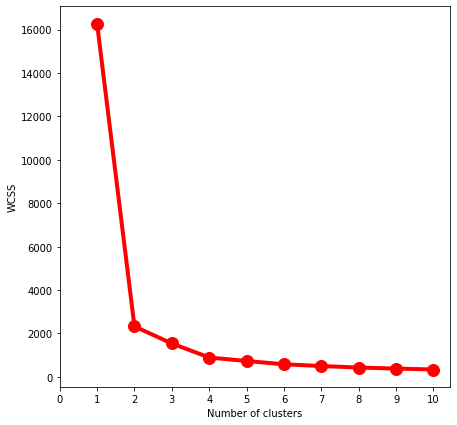

In [ ]:
#elbow method
#find the optimal number of clusters using elbow method  -- >This is for 2 features = ['location','age']
WCSS = []
for i in range(1,11):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(data_maxabs)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (7,7))
plt.plot(range(1,11),WCSS, linewidth=4, markersize=12,marker='o',color = 'red')
plt.xticks(np.arange(11))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

I ll ignore what the elbow method returns and i ll use 25 clusters because i want to divide the age groups and the locations into 5 each so 5*%=25

In [ ]:
model = KMeans(n_clusters = 25, init = "k-means++", max_iter = 500, n_init = 10, random_state = 0)
y_clusters = model.fit_predict(data_maxabs)

Visualization

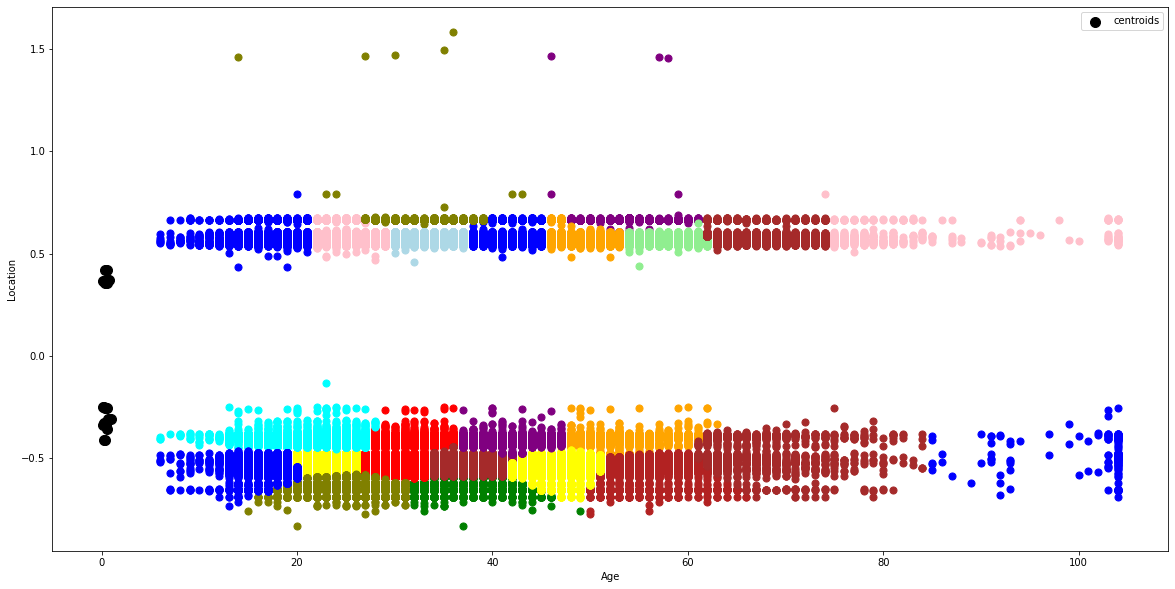

In [ ]:
plt.figure(figsize = (20,10))
plt.scatter(x[y_clusters == 0,0],x[y_clusters == 0,1],s = 50, c = 'green')
plt.scatter(x[y_clusters == 1,0],x[y_clusters == 1,1],s = 50, c = 'blue')
plt.scatter(x[y_clusters == 2,0],x[y_clusters == 2,1],s = 50, c = 'red')
plt.scatter(x[y_clusters == 3,0],x[y_clusters == 3,1],s = 50, c = 'blue')
plt.scatter(x[y_clusters == 4,0],x[y_clusters == 4,1],s = 50, c = 'orange')
plt.scatter(x[y_clusters == 5,0],x[y_clusters == 5,1],s = 50, c = 'yellow')
plt.scatter(x[y_clusters == 6,0],x[y_clusters == 6,1],s = 50, c = 'purple')
plt.scatter(x[y_clusters == 7,0],x[y_clusters == 7,1],s = 50, c = 'pink')
plt.scatter(x[y_clusters == 8,0],x[y_clusters == 8,1],s = 50, c = 'brown')
plt.scatter(x[y_clusters == 9,0],x[y_clusters == 9,1],s = 50, c = 'cyan')
plt.scatter(x[y_clusters == 10,0],x[y_clusters == 10,1],s = 50, c = 'olive')
plt.scatter(x[y_clusters == 11,0],x[y_clusters == 11,1],s = 50, c = 'lightgreen')
plt.scatter(x[y_clusters == 12,0],x[y_clusters == 12,1],s = 50, c = 'lightblue')
plt.scatter(x[y_clusters == 13,0],x[y_clusters == 13,1],s = 50, c = 'firebrick')
plt.scatter(x[y_clusters == 14,0],x[y_clusters == 14,1],s = 50, c = 'red')
plt.scatter(x[y_clusters == 15,0],x[y_clusters == 15,1],s = 50, c = 'blue')
plt.scatter(x[y_clusters == 16,0],x[y_clusters == 16,1],s = 50, c = 'orange')
plt.scatter(x[y_clusters == 17,0],x[y_clusters == 17,1],s = 50, c = 'yellow')
plt.scatter(x[y_clusters == 18,0],x[y_clusters == 18,1],s = 50, c = 'purple')
plt.scatter(x[y_clusters == 19,0],x[y_clusters == 19,1],s = 50, c = 'pink')
plt.scatter(x[y_clusters == 20,0],x[y_clusters == 20,1],s = 50, c = 'brown')
plt.scatter(x[y_clusters == 21,0],x[y_clusters == 21,1],s = 50, c = 'cyan')
plt.scatter(x[y_clusters == 22,0],x[y_clusters == 22,1],s = 50, c = 'olive')
plt.scatter(x[y_clusters == 23,0],x[y_clusters == 23,1],s = 50, c = 'blue')
plt.scatter(x[y_clusters == 24,0],x[y_clusters == 24,1],s = 50, c = 'brown')
plt.scatter(model.cluster_centers_[:,0],model.cluster_centers_[:,1], s = 100, c = "black", label = "centroids")
plt.xlabel("Age")
plt.ylabel("Location")
plt.legend()
plt.show()

**Append the cluster column into users inforamtion**

In [ ]:
######add the cluster attribute to the initial dataframe################
df_users = pd.read_csv("/content/sample_data/BX-Users.csv")
#remove the columns that has nan vals
#and
#remove the age less than 5 andd more than 100
df_users = df.drop(df[df['age'] >= 105].index)
df_users = df.drop(df[df['age'] <= 5].index)
df_users = df_users.dropna()

df_users['cluster'] = y_clusters
df_users.head()

,uid,location,age,cluster
1,2,"stockton, california, usa",18.0,3
3,4,"porto, v.n.gaia, portugal",17.0,9
5,6,"santa monica, california, usa",61.0,6
7,11,"melbourne, victoria, australia",14.0,23
9,13,"barcelona, barcelona, spain",26.0,22


**A function that gets a users id and a books id checks if the user has rated this book and if not it returns the avarage rating that other users that are in the same cluster has puted to this book**

In [ ]:
df_ratings = pd.read_csv("/content/sample_data/BX-Book-Ratings.csv")
df_books = pd.read_csv("/content/sample_data/BX-Books.csv",error_bad_lines=False, engine="python")
df_ratings = df_ratings.dropna()
df_books = df_books.dropna()
df_missing_ratings = pd.DataFrame(columns=['uid','isbn','rating'])
def avg_rating(uid,isbn):
  #get the cluster that contains the user
  cluster = df_users['cluster'].loc[df_users['uid'] == uid].values[0]
  #get all the users that are contained in this cluster
  users = df_users.loc[df_users['cluster'] == cluster, ['uid']]
  rating = 0
  counter = 0
  for user in users['uid']:
     if ((df_ratings['isbn'] == isbn) & (df_ratings['uid'] == user)).any():
        counter = counter + 1
        rating = rating + df_ratings.loc[(df_ratings['isbn'] == isbn) & (df_ratings['uid'] == user), ['rating']].values[0]
  try: 
    rating = rating/counter
  except ZeroDivisionError:
    pass
  counter = 0
  return rating

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version.





**Fill the missing ratings**

In [ ]:
 #for every user
for user in df_users['uid']:
  #for every book
  for book in df_books['isbn']:
    #if there isnt any rating 
    if ((df_ratings['uid'] == user) & (df_ratings['isbn'] == book)).any() == False:
      df_missing_ratings.append({'uid':user,"isbn":book,"rating":avg_rating(user,book)},ignore_index=True)


**Built of the csv for extraction**

In [ ]:
#to the ratings add cluster column
df_ratings2 = pd.merge(df_users, df_ratings, on="uid")
#to the ratings add informations about the book from the bx-books csv
df_ratings3 = pd.merge(df_ratings2,df_books,on='isbn')
print(df_ratings3)


          uid                         location   age  cluster        isbn  \
0           2        stockton, california, usa  18.0        3  0195153448   
1          19                        weston, ,  14.0        9  0375759778   
2       38502          new york, new york, usa  34.0       10  0375759778   
3      173180           corvallis, oregon, usa  30.0       12  0375759778   
4          20     langhorne, pennsylvania, usa  19.0        3  0425163091   
...       ...                              ...   ...      ...         ...   
22465  278818     allentown, pennsylvania, usa  15.0        3  0064405788   
22466  278820  ninety six, south carolina, usa  59.0       11  0399135790   
22467  278849      georgetown, ontario, canada  23.0        5  0445210214   
22468  278849      georgetown, ontario, canada  23.0        5  0771012837   
22469  278849      georgetown, ontario, canada  23.0        5  0920656307   

       rating                                     book_title  \
0          

**Extract csv into the drive**

In [ ]:
from google.colab import drive
drive.mount('/drive')
df_ratings3.to_csv('/drive/My Drive/Colab Notebooks/info_retrival/rating_with_clusters2.csv')



Mounted at /drive
